In [50]:
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import configparser
import momepy
import libpysal
import osmnx
import pandas
from bokeh.io import output_notebook
from bokeh.plotting import show
from clustergram import Clustergram
from shapely.geometry import Point
from numbers import Number
import inequality
import networkx as nx
local_crs = "EPSG:2039"
output_notebook()

Loading BokehJS ...

Load all the gdb files from michael folders

In [2]:

config = configparser.ConfigParser()
config_file = 'config.ini'
# check if file exists
if not os.path.isfile(config_file):
    # create a simple config file
    config['Paths'] = {'root_folder': ''}
    with open(config_file, 'w') as configfile:
        config.write(configfile)
    print(f"Created configuration file '{config_file}'.")

config.read('config.ini')

root_folder = config['Paths']['root_folder']  
print(root_folder)
root_folder = os.path.join(root_folder, "Michaels_Data")
print(root_folder)
# List all .gdb directories in the folder
gdb_files = []
for dirpath, dirnames, filenames in os.walk(root_folder):
    # Check if the folder contains a "commondata" folder
    if "commondata" in dirnames:
        commondata_folder = os.path.join(dirpath, "commondata")
        commondata_folder = os.path.normpath(commondata_folder)

        # List all .gdb files in the "commondata" folder
        for f in os.listdir(commondata_folder):
            if f.endswith('.gdb'):
                gdb_files.append(os.path.join(commondata_folder, f))

# Print the collected .gdb files
for gdb in gdb_files:
    print(gdb)
print("GDB Files:", gdb_files)

C:\\Users\\david\\Desktop\\DSSG
C:\\Users\\david\\Desktop\\DSSG\Michaels_Data
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\commondata\myproject16.gdb
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\commondata\scratch.gdb
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\חלקות\commondata\myproject16.gdb
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\חלקות\commondata\scratch.gdb
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\מרקמים\commondata\myproject16.gdb
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\מרקמים\commondata\scratch.gdb
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\קונטור בניינים\commondata\jps_reka.gdb
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\קונטור בניינים\commondata\scratch.gdb
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\רגישות\commondata\myproject16.gdb
C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\קונטור בניינים\commondata\scratch.gdb
C:\U

Calculating metrics over buildings:

In [3]:
# load municipal buildings
gdb_file = next((path for path in gdb_files if 'jps_reka.gdb' in path), None)
  # Modify if you want to choose a different .gdb
print(gdb_file)

# List the layers in the selected .gdb
layers = fiona.listlayers(gdb_file)
print("Layers in the selected GDB:", layers)

# Choose a specific layer within the .gdb
textures_layer = layers[0]  # Modify if you want to choose a different layer

# Load the specific layer
gdf = gpd.read_file(gdb_file, layer=textures_layer)

C:\Users\david\Desktop\DSSG\Michaels_Data\all_Layers\מרקמים\קונטור בניינים\commondata\jps_reka.gdb
Layers in the selected GDB: ['buildings']


In [4]:
buildings = gdf.to_crs(local_crs)

# remove the duplicates
duplicates = buildings[buildings.duplicated(subset='geometry', keep=False)]
buildings = buildings.drop_duplicates(subset='geometry', keep='first')
buildings = buildings.reset_index(drop=True)

In [5]:
# generates a random height for each building 
import numpy as np

# Generate random positive numbers
random_numbers = np.random.rand(len(buildings))

# Create a new column in the buildings DataFrame
buildings['building_height'] = random_numbers

In [6]:
# Calculate Building Height
# We need to have a 'height_col' or a similar column to calculate this

# Calculate Volume, requires floor_area and height
# Assuming height and area have been calculated and are stored in 'height' and 'floor_area' columns
buildings['floor_area'] = momepy.floor_area(buildings['Shape_Area'],buildings['building_height'])
buildings['volume'] = momepy.volume(buildings['Shape_Area'], buildings['building_height'])
buildings['form_factor'] = momepy.form_factor(buildings, buildings['building_height'])

In [7]:
# Basic geometric properties
buildings['perimeter'] = buildings.geometry.length
buildings['shape_index'] = momepy.shape_index(buildings,momepy.longest_axis_length(buildings))
buildings['circular_compactness'] = momepy.circular_compactness(buildings)
buildings['square_compactness'] = momepy.square_compactness(buildings)
buildings['weighted_axis_compactness'] = momepy.compactness_weighted_axis(buildings)
buildings['convexity'] = momepy.convexity(buildings)
buildings['courtyard_area'] = momepy.courtyard_area(buildings)
buildings['courtyard_index'] = momepy.courtyard_index(buildings)
buildings['corners'] = momepy.corners(buildings, include_interiors=True)   # include_interiors=False works only for polygons not multipolygons
buildings['fractal_dimension'] = momepy.fractal_dimension(buildings)
buildings['facade_ratio'] = momepy.facade_ratio(buildings)

c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\momepy\functional\_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\momepy\functional\_shape.py:887: RuntimeWarning: invalid value encountered in divide
  cosine_angle = np.sum(ba * bc, axis=1) / (


In [8]:
# More complex morphological metrics
buildings['orientation'] = momepy.orientation(buildings)
buildings['longest_axis_length'] = momepy.longest_axis_length(buildings)
buildings['equivalent_rectangular_index'] = momepy.equivalent_rectangular_index(buildings)
buildings['elongation'] = momepy.elongation(buildings)
buildings['linearity'] = momepy.linearity(buildings)
buildings['rectangularity'] = momepy.rectangularity(buildings)
buildings['squareness'] = momepy.squareness(buildings, include_interiors=True)  
buildings['shared_walls_length'] = momepy.shared_walls(buildings)

c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\momepy\functional\_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\momepy\functional\_shape.py:576: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(90 - degrees[true_angles]))
c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\momepy\functional\_shape.py:887: RuntimeWarning: invalid value encountered in divide
  cosine_angle = np.sum(ba * bc, axis=1) / (


In [9]:
# Metrics related to building adjacency and Graph
from libpysal import graph
delaunay = graph.Graph.build_triangulation(buildings.centroid,coplanar='clique').assign_self_weight()
orientation = momepy.orientation(buildings)
buildings['alignment'] = momepy.alignment(orientation, delaunay)

knn15 = graph.Graph.build_knn(buildings.centroid, k=15, coplanar='clique')  # adjust k if needed   
contiguity = graph.Graph.build_contiguity(buildings)
buildings['adjacency'] = momepy.building_adjacency(contiguity,knn15)
buildings['mean_interbuilding_distance'] = momepy.mean_interbuilding_distance(buildings, delaunay, knn15)
buildings['neighbour_distance'] = momepy.neighbor_distance(buildings, delaunay)
buildings['courtyards_num'] = momepy.courtyards(buildings, contiguity) # Calculate the number of courtyards within the joined structure

c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\libpysal\graph\base.py:1371: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  head, tail, weights = _delaunay(
c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\momepy\functional\_distribution.py:285: UserWarning: The indices of the two GeoSeries are different.
  (geoms.distance(geometry.geometry, align=True)).groupby(level=0).mean()


In [10]:
# the following metrics caculate the diversity index of building types, it's possible to override the binning method (refer to the full documentation)
knn5 = graph.Graph.build_knn(buildings.centroid, k=5)
for col in buildings.columns:
    if isinstance(buildings[col],Number):
        buildings[f'{col}_shannon'] = momepy.shannon(buildings[col], knn5)
        buildings[f'{col}_simpson'] = momepy.simpson(buildings[col], knn5)
        buildings[f'{col}_theil'] = momepy.theil(buildings[col], knn5)
        buildings[f'{col}_values_range'] = momepy.values_range(buildings[col], knn5)
        buildings[f'{col}_mean_deviation'] = momepy.mean_deviation(buildings[col], knn5)

In [11]:
# This is a modified version of the momepy.buffered_limit function that allows for adaptive buffer calculation on our data
from libpysal import graph
from packaging.version import Version
import numpy as np
def buffered_limit(gdf,buffer: float | str = 100,min_buffer: float = 0,max_buffer: float = 100,**kwargs,):
   
    if buffer == "adaptive":
        
        gabriel = graph.Graph.build_triangulation(gdf.centroid, "gabriel", kernel="identity", coplanar='clique')
        max_dist = gabriel.aggregate("max")
        buffer = np.clip(max_dist / 2 + max_dist * 0.1, min_buffer, max_buffer).values

    elif not isinstance(buffer, int | float):
        raise ValueError("`buffer` must be either 'adaptive' or a number.")

    GPD_GE_10 = Version(gpd.__version__) >= Version("1.0dev")
    return (
        gdf.buffer(buffer, **kwargs).union_all()
        if GPD_GE_10
        else gdf.buffer(buffer, **kwargs).unary_union
    )

In [12]:
# metrics related to tessellation
limit = buffered_limit(buildings, buffer = 'adaptive')
tessellation = momepy.morphological_tessellation(buildings) # need adjustment
blg_orient = momepy.orientation(buildings)
tess_orient = momepy.orientation(tessellation)
buildings['cell_orientation'] = momepy.cell_alignment(blg_orient, tess_orient)
buildings['num_of_neighbours'] = momepy.neighbors(tessellation, contiguity, weighted=True)

c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\libpysal\graph\base.py:1375: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  head, tail, weights = _gabriel(


Calculate metrics over streets

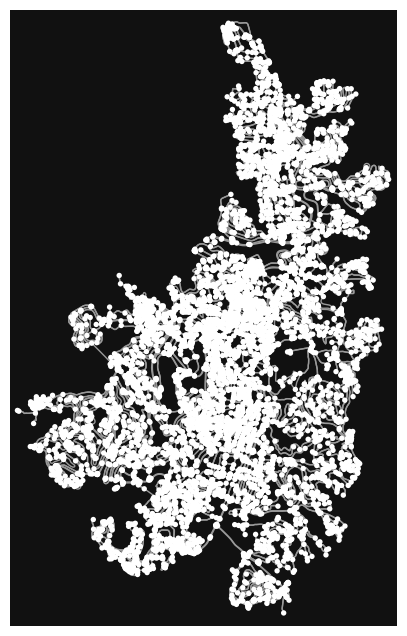

Index(['osmid', 'oneway', 'name', 'highway', 'reversed', 'length', 'from',
       'to', 'geometry', 'lanes', 'ref', 'maxspeed', 'tunnel', 'access',
       'junction', 'width', 'bridge', 'service'],
      dtype='object')


c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\momepy\utils.py:352: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [46]:
place = "Jerusalem, Israel"
local_crs = "EPSG:2039"


#Load open street streets:
osm_streets = osmnx.graph_from_place(place, network_type="drive")
osmnx.plot_graph(osm_streets)
osm_graph = osmnx.projection.project_graph(osm_streets, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(osm_streets),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)
print(streets.columns)
streets = streets.drop_duplicates(subset='geometry', keep='first')
streets_geometry = streets['geometry']
street_network_graph = momepy.gdf_to_nx(streets)

In [43]:
streets['orientation'] = momepy.orientation(streets_geometry)
streets['longest_axis_length'] = momepy.longest_axis_length(streets_geometry)

# todo : check if it is related to street length
streets['compactness_weighted_axis'] = momepy.compactness_weighted_axis(streets_geometry)
streets['linearity'] = momepy.linearity(streets_geometry)
queen_graph = libpysal.graph.Graph.build_contiguity(streets_geometry).assign_self_weight()
streets['alignment'] = momepy.alignment(streets['orientation'] ,queen_graph)
streets['cell_alignment'] = momepy.cell_alignment(streets['orientation'], osm_graph)
streets["length"] = streets.length
streets["linearity"] = momepy.linearity(streets)

#Calculates natural continuity and hierarchy of street networks
coins = momepy.COINS(streets)
stroke_gdf = coins.stroke_gdf()
stroke_attr = coins.stroke_attribute()
streets['continuity'] = coins.continuity
streets['hierarchy'] = coins.hierarchy


# apperantly every node has only one neighbor:
# streets['neighbors'] = momepy.neighbors(streets_geometry, queen_graph)





KeyboardInterrupt: 

In [61]:
street_network_graph = momepy.gdf_to_nx(streets)#street graph metrics:
nx.set_node_attributes(street_network_graph, dict(street_network_graph.degree()), 'degree')
# cds_length_result = momepy.cds_length(street_network_graph)

# # Check if the lengths match
# print(f"Length of cds_length result: {len(cds_length_result)}")
# print(f"Length of streets GeoDataFrame: {len(streets)}")

# Make sure they match before assignment
# if len(cds_length_result) == len(streets):
#     streets['cds_length'] = cds_length_result
# else:
#     print("Mismatch in lengths. Check graph and GeoDataFrame.")
# Calculates the shortest-path betweenness centrality for nodes.
# print(momepy.betweenness_centrality(street_network_graph))
# streets['betweenness_centrality'] = momepy.betweenness_centrality(street_network_graph)

#Calculates length of cul-de-sacs for subgraph around each node if radius is set, or for whole graph
cds_lengths = momepy.cds_length(street_network_graph, radius = 5)
print(cds_lengths)
nodes_gdf = osmnx .graph_to_gdfs(street_network_graph, nodes=True, edges=False)

# Add cds_lengths to the intersections GeoDataFrame
nodes_gdf['cds_length'] = nodes_gdf.index.map(cds_lengths)

# Inspect the result
print(nodes_gdf[['geometry', 'cds_length']].head())

c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\momepy\utils.py:352: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
100%|██████████| 7682/7682 [00:13<00:00, 557.10it/s]


MultiGraph with 7682 nodes and 10794 edges


TypeError: Must pass list-like as `names`.

metrics that not included on streets: Non related metrics for streets: courtyard_area, perimeter_wall, centroid_corner_distance, circular_compactness (works on polygons), convexity, corners, courtyard_index(relevant for closed polygons), elongation(how streched the polygon is), equivalent_rectangular_index, facade ratio, form_factor, fractal_dimension, rectangularity, shape_index, squere compactness, squareness

In [ ]:
# shared metrics between buildings and streets
# Ensure you have the necessary context (like street networks) for these:
# gdf_network =   # the street network
# buildings['node_density'] = momepy.node_density(gdf_network, buildings, radius=300)
# buildings['street_profile'] = momepy.street_profile(gdf_network, buildings, radius=300)
# buildings['reach'] = momepy.Reach(buildings, gdf_network, distance=500)

blg_orient = momepy.orientation(buildings)
str_orient = momepy.orientation(streets)
momepy.street_alignment(blg_orient, str_orient, buildings["street_index"])


In [ ]:

# ## test intersections metrics 
# street_network_graph = momepy.gdf_to_nx(streets)#street graph metrics:
# nx.set_node_attributes(street_network_graph, dict(street_network_graph.degree()), 'degree')
# # cds_length_result = momepy.cds_length(street_network_graph)

# # # Check if the lengths match
# # print(f"Length of cds_length result: {len(cds_length_result)}")
# # print(f"Length of streets GeoDataFrame: {len(streets)}")

# # Make sure they match before assignment
# # if len(cds_length_result) == len(streets):
# #     streets['cds_length'] = cds_length_result
# # else:
# #     print("Mismatch in lengths. Check graph and GeoDataFrame.")
# # Calculates the shortest-path betweenness centrality for nodes.
# # print(momepy.betweenness_centrality(street_network_graph))
# # streets['betweenness_centrality'] = momepy.betweenness_centrality(street_network_graph)

# #Calculates length of cul-de-sacs for subgraph around each node if radius is set, or for whole graph
# cds_lengths = momepy.cds_length(street_network_graph, radius = 5)
# print(cds_lengths)
# nodes_gdf = osmnx .graph_to_gdfs(street_network_graph, nodes=True, edges=False)

# # Add cds_lengths to the intersections GeoDataFrame
# nodes_gdf['cds_length'] = nodes_gdf.index.map(cds_lengths)

# # Inspect the result
# print(nodes_gdf[['geometry', 'cds_length']].head())

In [ ]:
# street_network_graph = momepy.gdf_to_nx(streets)#street graph metrics:
# nx.set_node_attributes(street_network_graph, dict(street_network_graph.degree()), 'degree')
# # cds_length_result = momepy.cds_length(street_network_graph)

# # # Check if the lengths match
# # print(f"Length of cds_length result: {len(cds_length_result)}")
# # print(f"Length of streets GeoDataFrame: {len(streets)}")

# # Make sure they match before assignment
# # if len(cds_length_result) == len(streets):
# #     streets['cds_length'] = cds_length_result
# # else:
# #     print("Mismatch in lengths. Check graph and GeoDataFrame.")
# # Calculates the shortest-path betweenness centrality for nodes.
# # print(momepy.betweenness_centrality(street_network_graph))
# # streets['betweenness_centrality'] = momepy.betweenness_centrality(street_network_graph)

# #Calculates length of cul-de-sacs for subgraph around each node if radius is set, or for whole graph
# cds_length = momepy.cds_length(street_network_graph, radius = 5)
# print(cds_length)
# streets['cds_length'] = momepy.cds_length(street_network_graph, radius = 5)

# #Calculates the closeness centrality for nodes. how node is "central"
# streets['closeness_centrality'] = momepy.closeness_centrality(osm_graph)

# # calcualtes for a node, how many of its neighbors are also neighbors with each other
# streets['clustering'] = momepy.clustering(osm_graph)

# #Calculates cyclomatic complexity (number of loopes) for subgraph around each node.
# streets['cyclomatic'] = momepy.cyclomatic(osm_graph)

# # calcualte the ratio of edge/node for a subgraph around each node
# streets['edge_node_ratio'] = momepy.edge_node_ratio(osm_graph)

# # calculate the gamma index - measure for the connectivity of a subgraph around a node.
# streets['gamma'] = momepy.gamma(osm_graph)

# #Calculates mean node degree for subgraph around each node
# streets['mean_node_degree'] = momepy.mean_node_degree(osm_graph)

# #Calculates mean distance to neighbouring nodes.
# streets['mean_node_dist'] = momepy.mean_node_dist(osm_graph)

# # returns the mean over the attribute of nodes. returns a single value?
# # streets['mean_nodes'] = momepy.mean_nodes(osm_graph)

# #For each node calcualte the ratio of face cycles to the maximum number of face cycles
# streets['meshedness'] = momepy.meshedness(osm_graph)

# #calculate the degree of each node
# streets['node_degree'] = momepy.node_degree(osm_graph)

# #Calculated how the network around nodes is dense - many nodes in a smaller area
# streets['node_density'] = momepy.node_density(osm_graph, radius=5)

# #Calculated the proportion of each special type of intersection/ total intersections of a subgraph
# # todo - checks what the function returns 
# streets['proportion'] = momepy.proportion(osm_graph)

# #checks how much a subgraph around a node is straight
# streets['straightness_centrality'] = momepy.straightness_centrality(osm_graph,radius=5)

# #Calculates natural continuity and hierarchy of street networks
# coins = momepy.COINS(streets)
# stroke_gdf = coins.stroke_gdf()
# stroke_attr = coins.stroke_attribute()
# streets['continuity'] = coins.continuity
# streets['hierarchy'] = coins.hierarchy

c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\momepy\utils.py:352: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
100%|██████████| 7682/7682 [00:15<00:00, 508.54it/s]


MultiGraph with 7682 nodes and 10794 edges


100%|██████████| 7682/7682 [00:14<00:00, 540.36it/s]


ValueError: Length of values (7682) does not match length of index (10794)